In [8]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import math
from math import sin, cos, atan2, degrees
import time

# Konstanten
BEACON0_POS = np.array([-10, 0])  # Position des linken Beacons
BEACON1_POS = np.array([10, 0])  # Position des rechten Beacons
DT = 0.1  # Zeitintervall (in Sek.)

def f_x(state, dt):
    """
    Zustandsübergangsfunktion.
    Berechnet die neue Position basierend auf der aktuellen Position und Geschwindigkeit.
    """
    x, y, vx, vy = state

    # Update position with current velocity
    new_x = x + vx * dt
    new_y = y + vy * dt

    # Velocity
    new_vx = vx
    new_vy = vy

    return np.array([new_x, new_y, new_vx, new_vy])

def h_x(state):
    """
    Messfunktion.
    Wandelt den Zustandsraum (Position und Geschwindigkeit) in Messwerte um (Winkel zu Funktürmen).
    """
    x, y = state[:2]

    def calculate_angle(beacon_pos):
        # Angle from ship to beacons
        angle = np.arctan2(beacon_pos[1] - y, beacon_pos[0] - x)
        # Adjust angles to defined orientation (0 north, 90 west, 180 south, 270 east)
        return (np.degrees(angle) + 270) % 360
        
    return np.array([calculate_angle(BEACON0_POS), calculate_angle(BEACON1_POS)])

def simulate_ship_movement(steps, dt):
    """
    Simuliert die Bewegung des Schiffs (für gegebene Anzahl an Einheiten/Schritten).
    """
    return [np.array([5 * math.sin(i * dt), -10 + 2 * i * dt, 0, 0]) for i in range(steps)]

def generate_noisy_measurements(states, std_0, std_1):
    """
    Erzeugt verrauschte Messdaten basierend auf wahren Zustände.
    """
    np.random.seed(int(time.time()))  # Alternativ auch '123456789'
    
    return [h_x(state) + np.random.randn(2) * np.array([std_0, std_1]) for state in states]

def initialize_ukf():
    """
    Initialisierung vom UKF.
    """
    sigmas = MerweScaledSigmaPoints(4, alpha=0.1, beta=2.0, kappa=1.0)
    ukf = UKF(dim_x=4, dim_z=2, fx=f_x, hx=h_x, dt=DT, points=sigmas)
    ukf.R = np.diag([std_0 ** 2, std_1 ** 2])
    ukf.Q = Q_discrete_white_noise(dim=2, dt=DT, var=0.02, block_size=2, order_by_dim=False)
    
    return ukf

def update_velocity(ukf, prev_state, dt):
    """
    Aktualisiert die Geschwindigkeit im UKF-Zustand basierend auf der Differenz der aktuellen und vorherigen Position.
    TODO: Ggf. Refaktorisierung in f_x (muss geklärt werden).
    """
    if prev_state is not None:
        dx = ukf.x[0] - prev_state[0]
        dy = ukf.x[1] - prev_state[1]
        ukf.x[2] = dx / dt  # Geschwindigkeit in X-Richtung
        ukf.x[3] = dy / dt  # Geschwindigkeit in Y-Richtung

# Main-Funktion
if __name__ == "__main__":

    # Erstellung von 100ms (10 Sek.) von Zuständen der Schiffsbewegung
    states = simulate_ship_movement(100, DT)

    # Std. Konfiguration und verrauschte Messdaten erzeugen
    std_0 = 0.01  # Std. für Beacon 0
    std_1 = 0.01  # Std. für Beacon 1
    zs = generate_noisy_measurements(states, std_0, std_1)

    # Init.
    ukf = initialize_ukf()
    ukf.x = states[0].copy()

    uxs = []  # Zustände
    prev_state = None

    for z in zs:

        ukf.R = np.diag([std_0 ** 2, std_1 ** 2])
        # ukf.Q = Q_discrete_white_noise(dim=2, dt=DT, var=0.02, block_size=2, order_by_dim=False)
        ukf.Q = Q_discrete_white_noise(dim=2, dt=DT, var=0.02, block_size=2, order_by_dim=False)
    
        ukf.predict()
        ukf.update(z)
        
        # Geschwindigkeit mit im Zustand aktualisieren
        #update_velocity(ukf, prev_state, DT)
        prev_state = ukf.x.copy()
        
        uxs.append(ukf.x.copy())

    uxs = np.array(uxs)

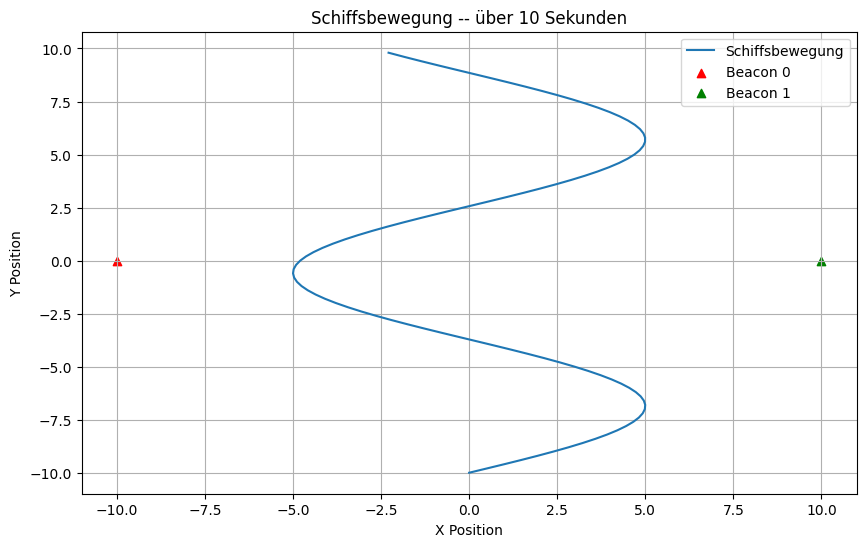

In [9]:
# Konvertieren
ship_positions = np.array(states)

# Grafik für die Schiffsbewegung
plt.figure(figsize=(10, 6))
plt.plot(ship_positions[:, 0], ship_positions[:, 1], label='Schiffsbewegung')
plt.scatter(*BEACON0_POS, color='red', marker='^', label='Beacon 0')
plt.scatter(*BEACON1_POS, color='green', marker='^', label='Beacon 1')
plt.title('Schiffsbewegung -- über 10 Sekunden')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

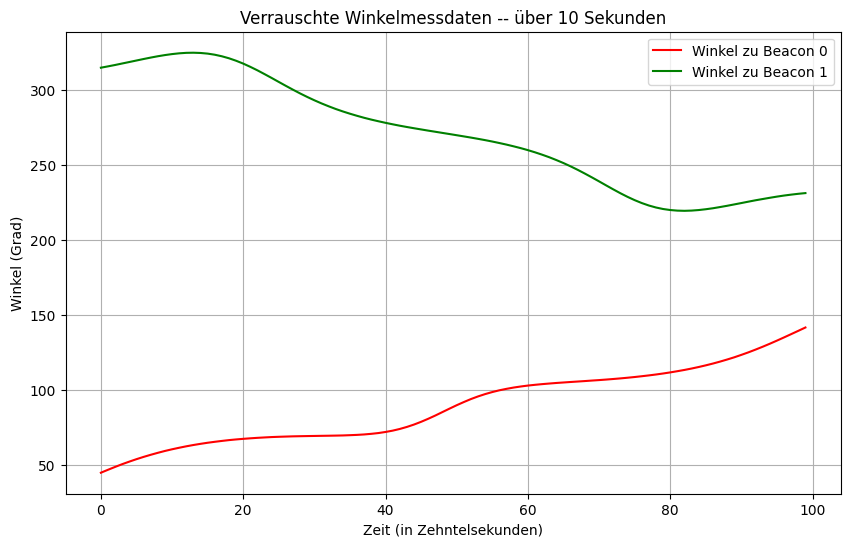

In [10]:
# Messdaten konvertieren für Grafik
noisy_measurements = np.array(zs)

# Grafik der verrauschten Messdaten
plt.figure(figsize=(10, 6))
plt.plot(noisy_measurements[:, 0], color='red', label='Winkel zu Beacon 0')
plt.plot(noisy_measurements[:, 1], color='green', label='Winkel zu Beacon 1')
plt.title('Verrauschte Winkelmessdaten -- über 10 Sekunden')
plt.xlabel('Zeit (in Zehntelsekunden)')
plt.ylabel('Winkel (Grad)')
plt.legend()
plt.grid(True)
plt.show()

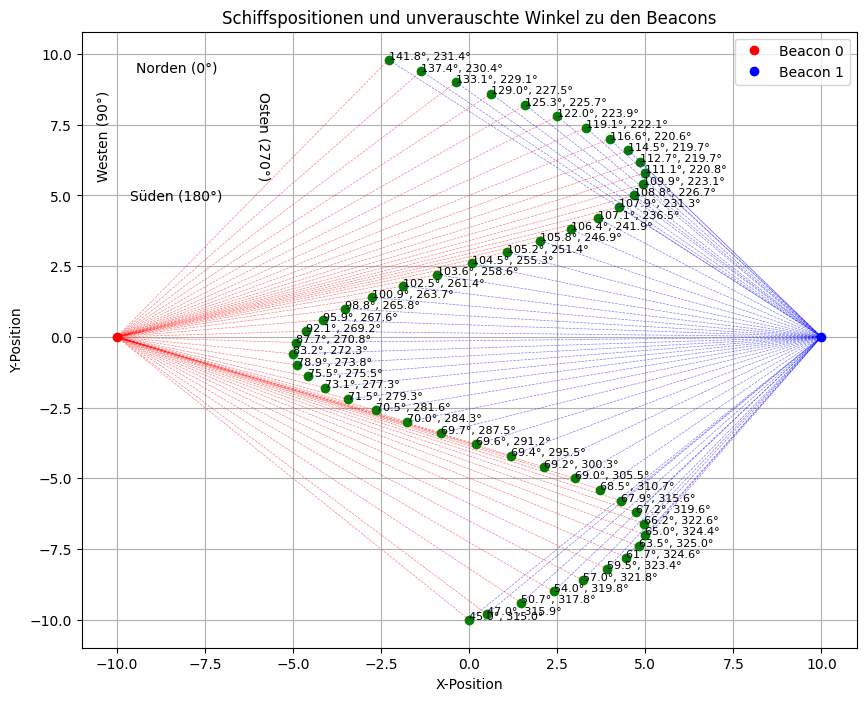

In [11]:
# Siehe h_x
def calculate_angle(beacon_pos, ship_pos):
    angle = atan2(beacon_pos[1] - ship_pos[1], beacon_pos[0] - ship_pos[0])
    return (degrees(angle) + 270) % 360


# Alle Winkel der Strecke anzeigen
plt.figure(figsize=(10, 8))

plt.plot(BEACON0_POS[0], BEACON0_POS[1], 'ro', label="Beacon 0")
plt.plot(BEACON1_POS[0], BEACON1_POS[1], 'bo', label="Beacon 1")

# Schiffspositionen und direkte Linien zu Beacons
for i, pos in enumerate(states):

    # Anzeigen der Winkel (Ungerade, erstes und letztes)
    if i == 0 or i % 2 == 1 or i == len(states) - 1:
        plt.plot(pos[0], pos[1], 'go')
        plt.plot([pos[0], BEACON0_POS[0]], [pos[1], BEACON0_POS[1]], 'r--', linewidth=0.5, alpha=0.5)
        plt.plot([pos[0], BEACON1_POS[0]], [pos[1], BEACON1_POS[1]], 'b--', linewidth=0.5, alpha=0.5)
        
        angle_to_beacon0 = calculate_angle(BEACON0_POS, pos)
        angle_to_beacon1 = calculate_angle(BEACON1_POS, pos)
        plt.text(pos[0], pos[1], f"{angle_to_beacon0:.1f}°, {angle_to_beacon1:.1f}°", fontsize=8)

plt.xlabel('X-Position')
plt.ylabel('Y-Position')
plt.title('Schiffspositionen und unverauschte Winkel zu den Beacons')
plt.legend()
plt.grid(True)

# Himmelsrichtungen
subax = plt.axes([0.12, 0.65, 0.2, 0.2]) # links, unten, Breite, Höhe
subax.text(0.5, 0.9, 'Norden (0°)', horizontalalignment='center')
subax.text(0.1, 0.5, 'Westen (90°)', verticalalignment='center', rotation=90)
subax.text(0.5, 0.1, 'Süden (180°)', horizontalalignment='center')
subax.text(0.9, 0.5, 'Osten (270°)', verticalalignment='center', rotation=270)


subax.axis('off')
plt.show()

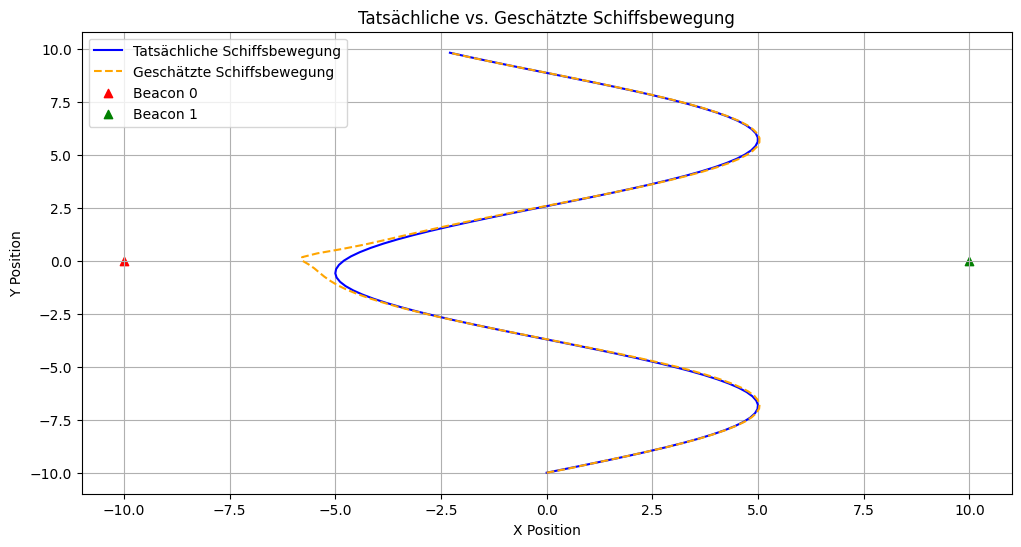

In [12]:
# Konvertieren der tatsächliche Schiffsbewegung
ship_positions = np.array(states)

# Grafik für die tatsächliche Schiffsbewegung
plt.figure(figsize=(12, 6))
plt.plot(ship_positions[:, 0], ship_positions[:, 1], label='Tatsächliche Schiffsbewegung', color='blue')

# Grafik für die vom UKF geschätzte Schiffsbewegung
plt.plot(uxs[:, 0], uxs[:, 1], label='Geschätzte Schiffsbewegung', color='orange', linestyle='--')

# Positionen der Beacons
plt.scatter(*BEACON0_POS, color='red', marker='^', label='Beacon 0')
plt.scatter(*BEACON1_POS, color='green', marker='^', label='Beacon 1')

# Konfiguration
plt.title('Tatsächliche vs. Geschätzte Schiffsbewegung')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()



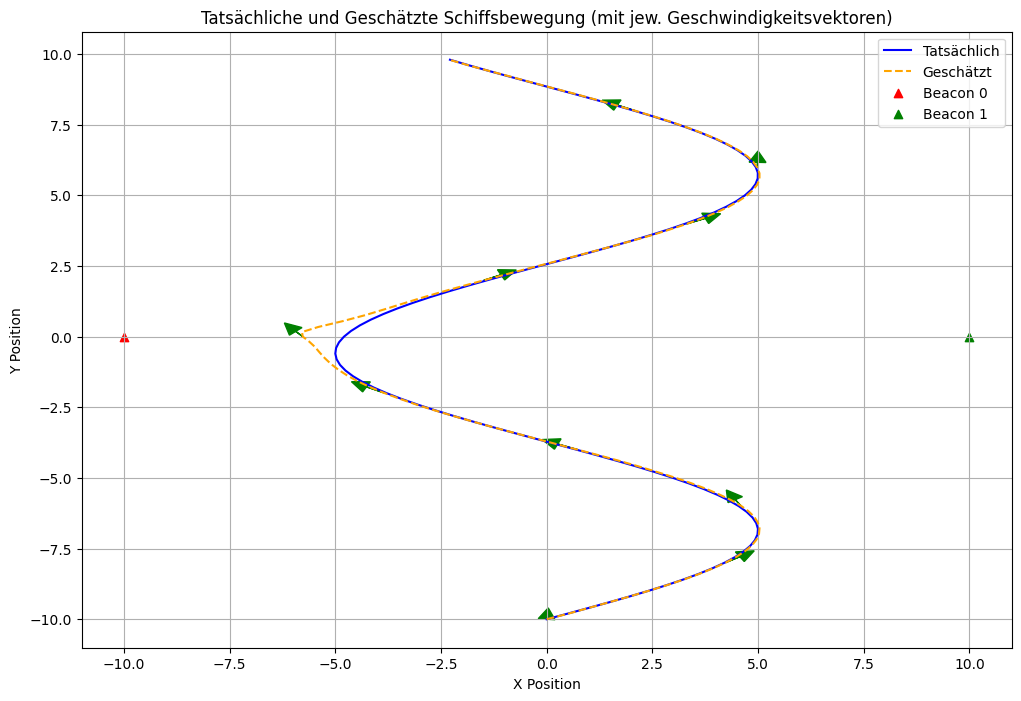

In [6]:
# Konvertieren der tatsächliche Schiffsbewegung
ship_positions = np.array(states)

# Tatsächliche Schiffsbewegung
simulated_positions = np.array([state[:2] for state in states])

# Grafik
plt.figure(figsize=(12, 8))

# Tatsächliche Strecke vom Schiff
plt.plot(ship_positions[:, 0], ship_positions[:, 1], label='Tatsächlich', color='blue')

# Vom UKF geschätzte Strecke vom Schiff
plt.plot(uxs[:, 0], uxs[:, 1], label='Geschätzt', color='orange', linestyle='--')

# Geschwindigkeitsvektoren
for i in range(0, len(uxs), 10):  # Zeige Vektoren alle 10 Schritte...
    state = uxs[i]
    plt.arrow(state[0], state[1], state[2] * DT, state[3] * DT, head_width=0.4, head_length=0.4, fc='green', ec='green')

# Konfiguration
plt.scatter(*BEACON0_POS, color='red', marker='^', label='Beacon 0')
plt.scatter(*BEACON1_POS, color='green', marker='^', label='Beacon 1')
plt.title('Tatsächliche und Geschätzte Schiffsbewegung (mit jew. Geschwindigkeitsvektoren)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()
